<a href="https://colab.research.google.com/github/gain16/portfolioAI/blob/master/CNN_to_predict_Sign_Language_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN to predict Sign Language images

### Your own image classification system
- Create an image classification system using a variety of sign Language images, rather than relying solely on the pre-existing sample data provided by Tensorflow.
- Compare the two cases as you change the activation function.(Relu and Softmax)

## Setup

Import TensorFlow and other necessary libraries:

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Helper libraries
import numpy as np # matrix 연산
import matplotlib.pyplot as plt # 그림 그리기

## Data downLoad and prepare (Google Drive Mount)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import shutil

shutil.copy('/content/gdrive/MyDrive/Colab Notebooks/CV_sign_language_filterted/sign_language_filtered.zip', '/content/')

'/content/sign_language_filtered.zip'

In [ ]:
# It will delete existing generated files on repeated runs.
# 반복적인 실행시 기존의 생성된 파일을 삭제해 줍니다.
root_dir = '/content'

import os

if os.path.exists(os.path.join(root_dir, 'sign_language_filtered')):
    shutil.rmtree(os.path.join(root_dir, 'sign_language_filtered'))

In [ ]:
# Import the compressed file module.
# 압축파일 모듈 import해 줍니다.
import zipfile

# Use the Python with function to make the sign_language_filtered.zip file accessible as target_file.
# 파이썬 with함수를 사용해서 sign_language_filtered.zip 파일을 target_file으로 접근하게 만듭니다.
with zipfile.ZipFile(os.path.join(root_dir, 'sign_language_filtered.zip'), mode='r') as target_file: # mode='r' (읽기 모드)

  target_file.extractall(os.path.join(root_dir, 'sign_language_filtered')) # Unzip the zip file to that path.(해당 경로에 zip파일을 해제)

In [ ]:
# Convert HEIC files to jpegs
# HEIC파일을 jpeg파일로 변환

!pip install pyheif
!pip install Pillow

import os
import pyheif
from PIL import Image

root_dir = '/content'
dataset_class = ['train','test']

for dataset_name in dataset_class:
  folder_path = os.path.join(root_dir, 'sign_language_filtered', dataset_name)
  for label in range(1, 11):
    class_folder = os.path.join(folder_path, str(label))
    for filename in os.listdir(class_folder):
        if filename.lower().endswith(".heic"):
           input_path = os.path.join(class_folder, filename)
           output_path = os.path.join(class_folder, f"{os.path.splitext(filename)[0]}.jpeg")

           heif_file = pyheif.read(input_path)
           image = Image.frombytes(
              heif_file.mode,
              heif_file.size,
              heif_file.data,
              "raw"
           )
           image.save(output_path, "jpeg")
           os.remove(input_path) # Remove existing HEIC files (기존 HEIC파일 제거)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Check the data quantity after downloading

* There are 777 images in the train folder
* There are 330 images in the test folder

There are 1107 images in total.

In [ ]:
train_dir = os.path.join(root_dir, 'sign_language_filtered/train/')
test_dir = os.path.join(root_dir, 'sign_language_filtered/test/')

In [ ]:
import pathlib
from pathlib import Path

train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir)

# Check the number of images in the training and test datasets.
# 훈련용데이터셋 과 테스트용데이터셋의 이미지수량을 확인한다.
train_image_count = len(list(train_dir.glob('*/*.*'))) #glob는 문자열 객체에서 호출할수 없다. 그래서 pathlib.path를 사용
test_image_count = len(list(test_dir.glob('*/*.*')))   #왜 */*으로 가운데 '/'가 들어가는지 확인하기

print(train_image_count)
print(test_image_count)
total = int(train_image_count) + int(test_image_count)
print(total)

777
330
1107


Functions for turning data into numpy array format

In [ ]:
def load_images_from_folder(folder_path, target_size):
    images = []
    labels = []
    for label in range(1, 11):
        class_folder = os.path.join(folder_path, str(label))
        for filename in os.listdir(class_folder):
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                image_path = os.path.join(class_folder, filename)

                # Load the image and resize it to the desired size
                # 이미지를 불러온 후, 원하는 크기로 리사이즈한다
                image = Image.open(image_path).resize(target_size)

                # Convert the resized image to a Numpy array
                # 리사이즈된 이미지를 NumPy 배열로 변환한다
                numpy_array = np.array(image)
                images.append(numpy_array)
                labels.append(label-1)  # 레이블을 0부터 시작하게 조정
    return np.array(images), np.array(labels)

In [ ]:
target_size = (28, 28)  # Specify the desired image size (원하는 이미지 크기를 지정한다)

train_dir = os.path.join(root_dir, 'sign_language_filtered', 'train')
train_images, train_labels = load_images_from_folder(train_dir, target_size)

test_dir = os.path.join(root_dir, 'sign_language_filtered', 'test')
test_images, test_labels = load_images_from_folder(test_dir, target_size)

In [ ]:
# Check Train Dataset Numpy array Format
print(train_images.shape)
print(train_labels.shape)
print(type(train_images))
print(type(train_labels))

(777, 28, 28, 3)
(777,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
# Check Test Dataset Numpy array Format
print(test_images.shape)
print(test_labels.shape)
print(type(test_images))
print(type(test_labels))

(330, 28, 28, 3)
(330,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# Image Classification with CNN

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 160
img_width = 160

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2, # 80% train / 20% validation
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 777 files belonging to 10 classes.
Using 622 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 777 files belonging to 10 classes.
Using 155 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
train_np = list(train_ds)
val_np = list(val_ds)

In [ ]:
len(train_np[0])

2

In [ ]:
train_np[0][0].shape

TensorShape([32, 160, 160, 3])

In [ ]:
train_np[0][1]

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([8, 1, 1, 4, 2, 5, 0, 3, 3, 1, 5, 4, 7, 6, 5, 3, 2, 9, 2, 0, 1, 4,
       2, 2, 8, 3, 2, 4, 1, 7, 1, 6], dtype=int32)>

## Visualize the data

Here are the first ten images from the training dataset:

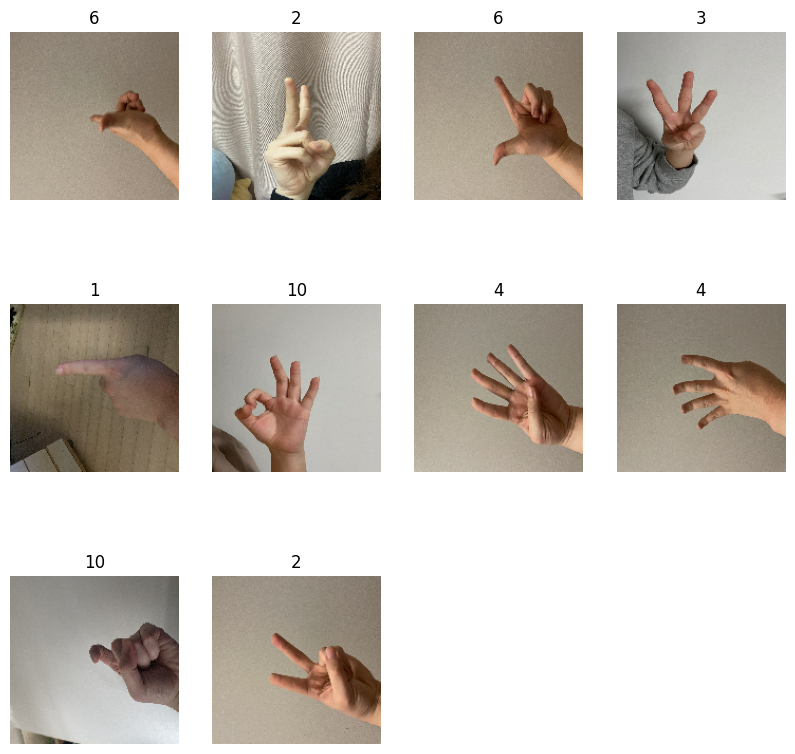

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [ ]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9798034


# Case1) Activation function of Dense layer → relu

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [ ]:
# Data Augmenation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

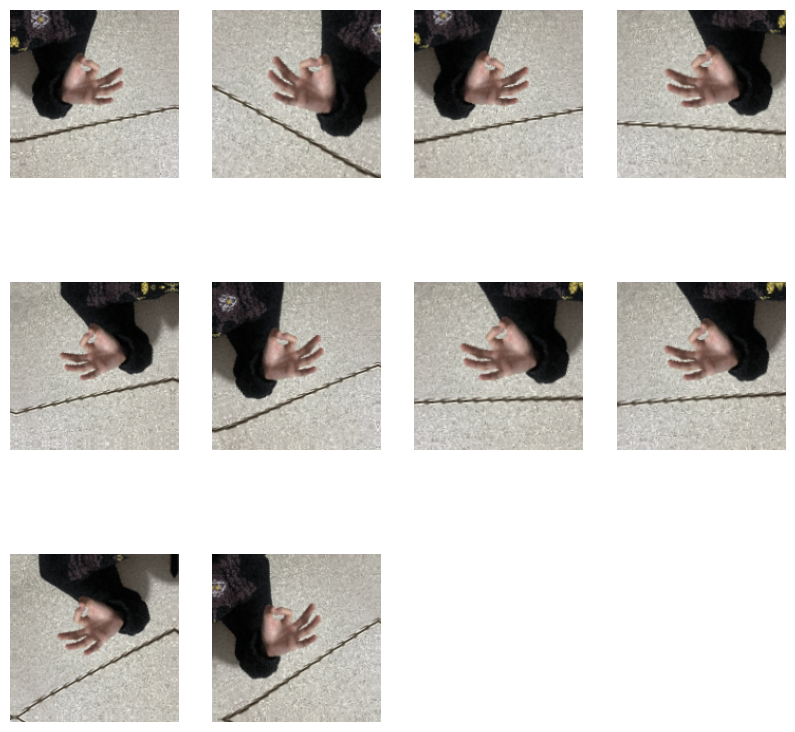

In [ ]:
# Data Augmenation Output the results
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(10):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Create the convolutional base

Building a simple CNN model with Conv2D, Maxpool, Conv2D

Introduced [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network to reduce overfitting.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation, # 데이터 어그멘테이션 추가
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # dropout 사용
  layers.Flatten(),
  layers.Dense(128, activation='relu'), # Activation function을 relu로 사용
  layers.Dense(num_classes)
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 80, 80, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                  

In [ ]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
20/20 [==============================] - 11s 471ms/step - loss: 2.3241 - accuracy: 0.1543 - val_loss: 2.2717 - val_accuracy: 0.1806
Epoch 2/100
20/20 [==============================] - 1s 32ms/step - loss: 2.2633 - accuracy: 0.1785 - val_loss: 2.3010 - val_accuracy: 0.1806
Epoch 3/100
20/20 [==============================] - 0s 22ms/step - loss: 2.2259 - accuracy: 0.1897 - val_loss: 2.2249 - val_accuracy: 0.1806
Epoch 4/100
20/20 [==============================] - 0s 22ms/step - loss: 2.1790 - accuracy: 0.1977 - val_loss: 2.2834 - val_accuracy: 0.1484
Epoch 5/100
20/20 [==============================] - 0s 22ms/step - loss: 2.1196 - accuracy: 0.2428 - val_loss: 2.1671 - val_accuracy: 0.1742
Epoch 6/100
20/20 [==============================] - 0s 21ms/step - loss: 2.0289 - accuracy: 0.2540 - val_loss: 2.0592 - val_accuracy: 0.2452
Epoch 7/100
20/20 [==============================] - 0s 22ms/step - loss: 1.9261 - accuracy: 0.2942 - val_loss: 2.0327 - val_accuracy: 0.2710
Epoc

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

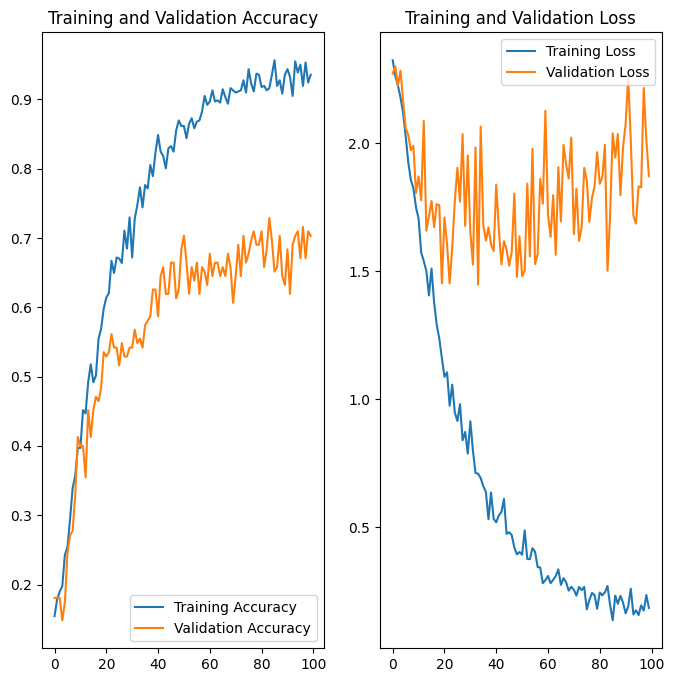

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Case2) Activation function of Dense layer → softmax

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation, #데이터 어그멘테이션 추가
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), #dropout 사용
  layers.Flatten(),
  layers.Dense(128, activation='softmax'), # Activation function을 softmax로 사용
  layers.Dense(num_classes)
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 80, 80, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 40, 40, 32)       0         
 g2D)                                                 

In [ ]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
20/20 [==============================] - 3s 33ms/step - loss: 2.2937 - accuracy: 0.1704 - val_loss: 2.2871 - val_accuracy: 0.1806
Epoch 2/100
20/20 [==============================] - 0s 22ms/step - loss: 2.2884 - accuracy: 0.1752 - val_loss: 2.2918 - val_accuracy: 0.1806
Epoch 3/100
20/20 [==============================] - 0s 22ms/step - loss: 2.2852 - accuracy: 0.1752 - val_loss: 2.2904 - val_accuracy: 0.1806
Epoch 4/100
20/20 [==============================] - 0s 22ms/step - loss: 2.2833 - accuracy: 0.1752 - val_loss: 2.2888 - val_accuracy: 0.1806
Epoch 5/100
20/20 [==============================] - 0s 22ms/step - loss: 2.2818 - accuracy: 0.1752 - val_loss: 2.2879 - val_accuracy: 0.1806
Epoch 6/100
20/20 [==============================] - 0s 22ms/step - loss: 2.2808 - accuracy: 0.1752 - val_loss: 2.2870 - val_accuracy: 0.1806
Epoch 7/100
20/20 [==============================] - 0s 23ms/step - loss: 2.2796 - accuracy: 0.1752 - val_loss: 2.2863 - val_accuracy: 0.1806
Epoch 

## Visualize training results

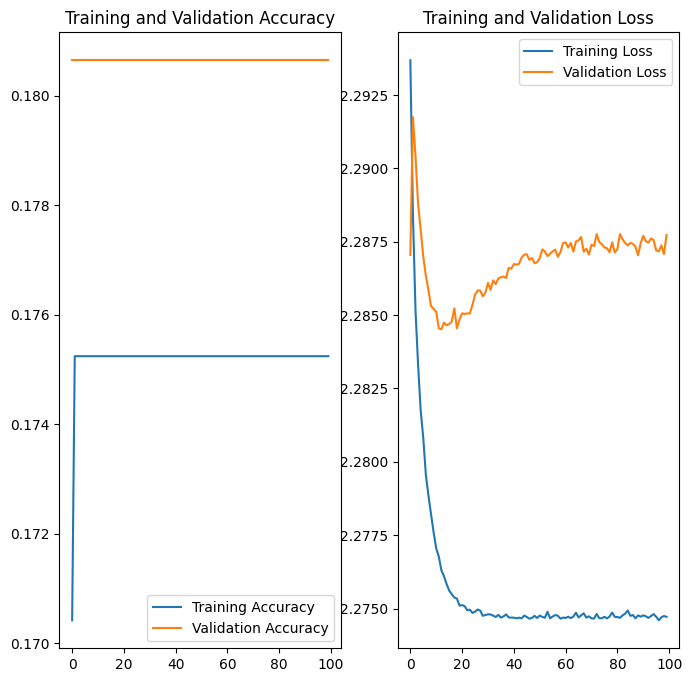

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Conclusion:
- It is difficult to learn with small amounts of data.

- There are different models for different data characteristics.
  For this data, relu was more appropriate than softmax for activation.

- Typically, when we apply deep learning, we apply models with a specific structure, such as CNN or Transformer, and these models may not be the right structure to learn the data for this particular sale.

- Just like the right tool for the right situation, the right machine learning model for the right problem will vary (deep learning is not one-size-fits-all).
